In [1]:
import h3
import pandas as pd

In [2]:
input_file = "C:/Users/freud/Tensorflow/DataFrames/all_waybill_info_meituan_0322.csv"
#output_file = "C:/Users/freud/Tensorflow/DataFrames/FileWithHexaGrid8.csv"

In [33]:
dataM = pd.read_csv(input_file)

In [34]:
resolution = 8

In [35]:
min_lat = 0
min_lon = 0
max_lat = 46000000
max_lon = 174700000

"first we will filter the data and remvoing a order area encupsuled from the main area of operation"

dataM = dataM[
        (dataM['recipient_lat'] >= min_lat) &
        (dataM['recipient_lat'] <= max_lat) &
        (dataM['recipient_lng'] >= min_lon) &
        (dataM['recipient_lng'] <= max_lon) &
        (dataM['sender_lat'] >= min_lat) &
        (dataM['sender_lat'] <= max_lat) &
        (dataM['sender_lng'] >= min_lon) &
        (dataM['sender_lng'] <= max_lon)] 

dataM = dataM[dataM['is_courier_grabbed'] != 0].reset_index(drop=True) #data cleaning
dataM = dataM[dataM['estimate_meal_prepare_time'] != 0].reset_index(drop=True) #data cleaning

In [36]:
dataM["latitude"] = (dataM["sender_lat"] / 1_000_000).astype(float)
dataM["longitude"] = (dataM["sender_lng"] / 1_000_000).astype(float)

In [37]:
dataM["h3_index"] = dataM.apply(lambda row: h3.latlng_to_cell(row["latitude"], row["longitude"], resolution), axis=1)


In [38]:
unique_hexagons = dataM["h3_index"].unique()

In [39]:
# **2. Mapping von H3-Index auf hexagon-Label und Zentroid-Koordinaten erstellen**
hexagon_mapping = {}
for i, h3_id in enumerate(unique_hexagons):
    hexagon_mapping[h3_id] = {
        "new_area_id": f"hexagon{i+1}",
        "hex_center_lat": h3.cell_to_latlng(h3_id)[0],  # Latitude of hexagon center
        "hex_center_lng": h3.cell_to_latlng(h3_id)[1],  # Longitude of hexagon center
    }

In [40]:
# **3. Neue Spalten "area_id", "hex_center_lat", "hex_center_lng" hinzufügen**
dataM["new_area_id"] = dataM["h3_index"].map(lambda x: hexagon_mapping[x]["new_area_id"])
dataM["hex_center_lat"] = dataM["h3_index"].map(lambda x: hexagon_mapping[x]["hex_center_lat"])
dataM["hex_center_lng"] = dataM["h3_index"].map(lambda x: hexagon_mapping[x]["hex_center_lng"])

In [41]:
# Relevante Spalten speichern
df_output = dataM[["order_id", "latitude", "longitude", "h3_index", "new_area_id", "hex_center_lat", "hex_center_lng","platform_order_time"]]
#df_output.to_csv(output_file, index=False, float_format="%.6f")

In [42]:
df_output

,order_id,latitude,longitude,h3_index,new_area_id,hex_center_lat,hex_center_lng,platform_order_time
0,1,45.905850,174.529930,88329b5883fffff,hexagon1,45.906551,174.534859,1665935995
1,2,45.861460,174.532407,88329b5abbfffff,hexagon2,45.857903,174.531290,1665937097
2,3,45.868015,174.559718,88329b5aa3fffff,hexagon3,45.864332,174.563614,1665937028
3,4,45.868015,174.559718,88329b5aa3fffff,hexagon3,45.864332,174.563614,1665937092
4,5,45.920329,174.542688,88329b58bdfffff,hexagon4,45.920317,174.543840,1665938399
...,...,...,...,...,...,...,...,...
517967,568542,45.879427,174.650494,88329b5863fffff,hexagon12,45.878522,174.650278,1666622390
517968,568543,45.868634,174.575022,88329b5aa7fffff,hexagon49,45.869380,174.573941,1666623313
517969,568544,45.879398,174.650478,88329b5863fffff,hexagon12,45.878522,174.650278,1666624923
517970,162081,45.889549,174.535543,88329b58d5fffff,hexagon46,45.889114,174.537562,1666626599


In [43]:
import pandas as pd

# Data laden
df2 = df_output
# Schritt 1: Areas mit < 200 Orders rausfiltern
area_counts = df2['new_area_id'].value_counts()
valid_areas = area_counts[area_counts >= 1000].index
df_filtered = df2[df2['new_area_id'].isin(valid_areas)]


In [44]:
df_aggregate = dataM[["order_id", "h3_index", "hex_center_lat", "hex_center_lng"]]

In [45]:
# Aggregation nach h3_index: Zähle Bestellungen pro Zelle
aggregated = df_aggregate.groupby('h3_index').agg(
    order_count=('order_id', 'count'),
    hex_center_lat=('hex_center_lat', 'min'),
    hex_center_lng=('hex_center_lng', 'max'),
).reset_index()

In [46]:
aggregated

,h3_index,order_count,hex_center_lat,hex_center_lng
0,88329b430dfffff,50,45.863851,174.485935
1,88329b4325fffff,2,45.891398,174.503871
2,88329b432dfffff,202,45.882679,174.505227
3,88329b4343fffff,17,45.850074,174.476972
4,88329b4345fffff,123,45.851465,174.498969
...,...,...,...,...
134,88329b5ae3fffff,1591,45.843217,174.577978
135,88329b5ae5fffff,84,45.844588,174.599971
136,88329b5ae7fffff,4290,45.848264,174.588303
137,88329b5ae9fffff,163,45.830819,174.590990


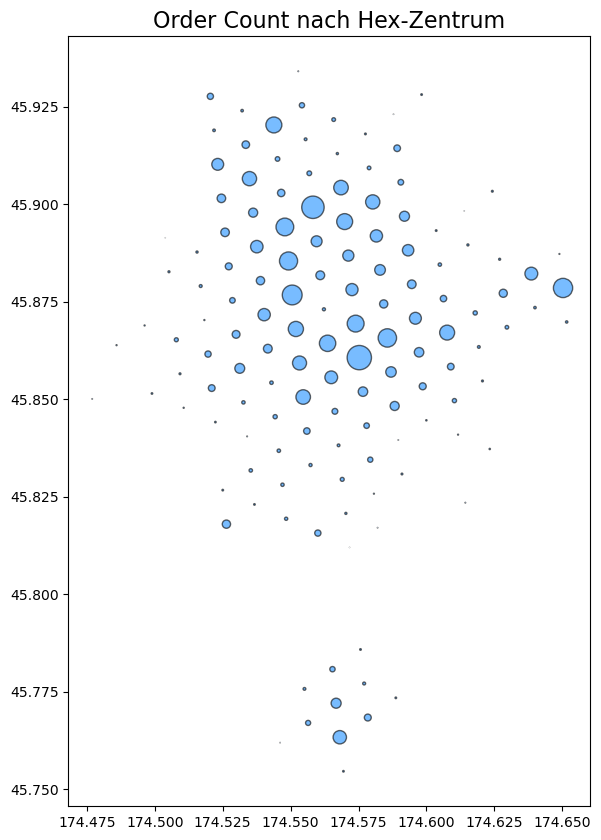

In [47]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point

# DataFrame laden
df = aggregated

# GeoDataFrame mit Punkt-Geometrien
gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df['hex_center_lng'], df['hex_center_lat']),
    crs="EPSG:4326"
)

# Plot
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(
    ax=ax,
    markersize=gdf['order_count'] / 100,  # anpassen je nach Skala
    color='dodgerblue',
    alpha=0.6,
    edgecolor='black'
)
plt.title("Order Count nach Hex-Zentrum", fontsize=16)
plt.show()
